In [2]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultTrainer, HookBase
from detectron2.data import build_detection_train_loader, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import matplotlib.pyplot as plt
import json
import os
import cv2

# 假设 VOC 数据集的格式已转换为 COCO 格式
path = '/mnt/d/复旦/研究生/研一下/神经网络与深度学习/Homework2/VOCtrainval_11-May-2012/VOCdevkit/VOC2012'

In [2]:
def remove_existing_dataset(dataset_name):
    if dataset_name in DatasetCatalog.list():
        DatasetCatalog.remove(dataset_name)
    if dataset_name in MetadataCatalog.list():
        MetadataCatalog.remove(dataset_name)

# 使用示例
dataset_name = "voc_2012_train"
remove_existing_dataset(dataset_name)
dataset_name = "voc_2012_val"
remove_existing_dataset(dataset_name)

In [3]:
register_coco_instances("voc_2012_train", {}, path + '/train/train.json', path + '/train/images')
register_coco_instances("voc_2012_val", {}, path + '/val/val.json', path + '/val/images')

In [4]:
voc_metadata = MetadataCatalog.get("voc_2012_train")

In [5]:
class CustomTrainer(DefaultTrainer):
    def __init__(self, cfg):
        super().__init__(cfg)
    
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1, LossEvalHook(self.cfg, self.model))
        return hooks

class LossEvalHook(HookBase):
    def __init__(self, cfg, model):
        self.cfg = cfg.clone()
        self.model = model
        self.val_loader = build_detection_test_loader(cfg, "voc_2012_val")

    def after_step(self):
        if self.trainer.iter % 20 == 0:  # 每隔 20 次迭代进行一次评估，可根据需要调整频率
            evaluator = COCOEvaluator("voc_2012_val", output_dir=self.cfg.OUTPUT_DIR)
            results = inference_on_dataset(self.model, self.val_loader, evaluator)
            val_loss = sum(x[0] for x in self.trainer.storage.history("total_loss").values()) / len(self.trainer.storage.history("total_loss").values())
            self.trainer.storage.put_scalar("val_loss", val_loss)
            self.trainer.storage.put_scalar("val_map", results["bbox"]["AP"])

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("voc_2012_train",)
cfg.DATASETS.TEST = ("voc_2012_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 1500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 20
cfg.OUTPUT_DIR = "/mnt/d/复旦/研究生/研一下/神经网络与深度学习/Homework2/output"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/20 23:11:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (21, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (21,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (80, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (80,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias

[05/20 23:11:30 d2.engine.train_loop]: Starting training from iteration 0


/home/zsw_fdu/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/20 23:11:31 d2.evaluation.evaluator]: Start inference on 3425 batches
[05/20 23:11:32 d2.evaluation.evaluator]: Inference done 11/3425. Dataloading: 0.0007 s/iter. Inference: 0.0798 s/iter. Eval: 0.0003 s/iter. Total: 0.0807 s/iter. ETA=0:04:35
[05/20 23:11:38 d2.evaluation.evaluator]: Inference done 73/3425. Dataloading: 0.0010 s/iter. Inference: 0.0805 s/iter. Eval: 0.0003 s/iter. Total: 0.0819 s/iter. ETA=0:04:34
[05/20 23:11:43 d2.evaluation.evaluator]: Inference done 135/3425. Dataloading: 0.0011 s/iter. Inference: 0.0803 s/iter. Eval: 0.0003 s/iter. Total: 0.0818 s/iter. ETA=0:04:29
[05/20 23:11:48 d2.evaluation.evaluator]: Inference done 196/3425. Dataloading: 0.0011 s/iter. Inference: 0.0800 s/iter. Eval: 0.0010 s/iter. Total: 0.0821 s/iter. ETA=0:04:25
[05/20 23:11:53 d2.evaluation.evaluator]: Inference done 259/3425. Dataloading: 0.0011 s/iter. Inference: 0.0796 s/iter. Eval: 0.0008 s/iter. Total: 0.0815 s/iter. ETA=0:04:17
[05/20 23:11:58 d2.evaluation.evaluator]: Infere

2024-05-20 23:16:14.055814: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-20 23:16:14.385649: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 23:16:14.385692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 23:16:14.437493: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-20 23:16:14.543067: I tensorflow/core/platform/cpu_feature_guar

[05/20 23:16:17 d2.evaluation.evaluator]: Start inference on 3425 batches
[05/20 23:16:18 d2.evaluation.evaluator]: Inference done 11/3425. Dataloading: 0.0006 s/iter. Inference: 0.0743 s/iter. Eval: 0.0003 s/iter. Total: 0.0752 s/iter. ETA=0:04:16
[05/20 23:16:23 d2.evaluation.evaluator]: Inference done 76/3425. Dataloading: 0.0010 s/iter. Inference: 0.0757 s/iter. Eval: 0.0003 s/iter. Total: 0.0770 s/iter. ETA=0:04:18
[05/20 23:16:28 d2.evaluation.evaluator]: Inference done 140/3425. Dataloading: 0.0011 s/iter. Inference: 0.0763 s/iter. Eval: 0.0003 s/iter. Total: 0.0777 s/iter. ETA=0:04:15
[05/20 23:16:33 d2.evaluation.evaluator]: Inference done 204/3425. Dataloading: 0.0011 s/iter. Inference: 0.0765 s/iter. Eval: 0.0003 s/iter. Total: 0.0779 s/iter. ETA=0:04:10
[05/20 23:16:38 d2.evaluation.evaluator]: Inference done 268/3425. Dataloading: 0.0011 s/iter. Inference: 0.0768 s/iter. Eval: 0.0003 s/iter. Total: 0.0782 s/iter. ETA=0:04:06
[05/20 23:16:43 d2.evaluation.evaluator]: Infere

In [14]:
# 读取训练日志
with open(os.path.join("/mnt/d/复旦/研究生/研一下/神经网络与深度学习/Homework2/output", "metrics.json")) as f:
    metrics = [json.loads(line) for line in f]

# 提取损失和验证集MAP
iterations = [x["iteration"] for x in metrics if "total_loss" in x]
loss = [x["total_loss"] for x in metrics if "total_loss" in x]
val_loss = [x["val_loss"] for x in metrics if "val_loss" in x]
map_values = [x["val_map"] for x in metrics if "val_map" in x]

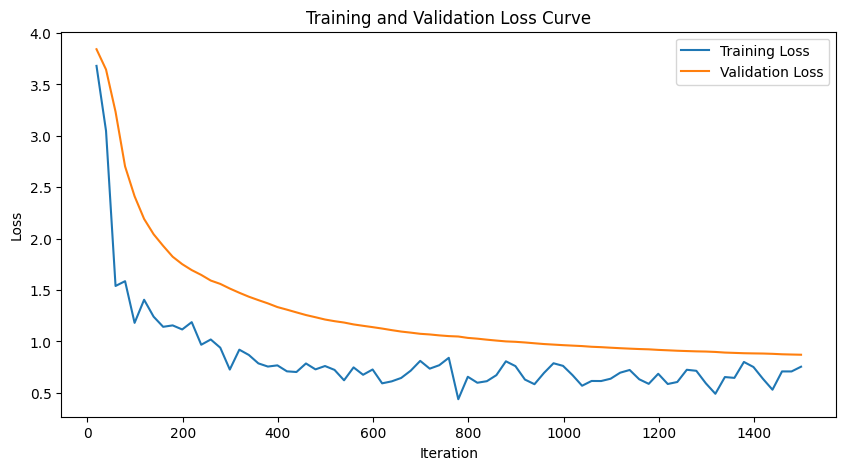

In [15]:
# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(iterations, loss, label='Training Loss')
plt.plot(iterations, val_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

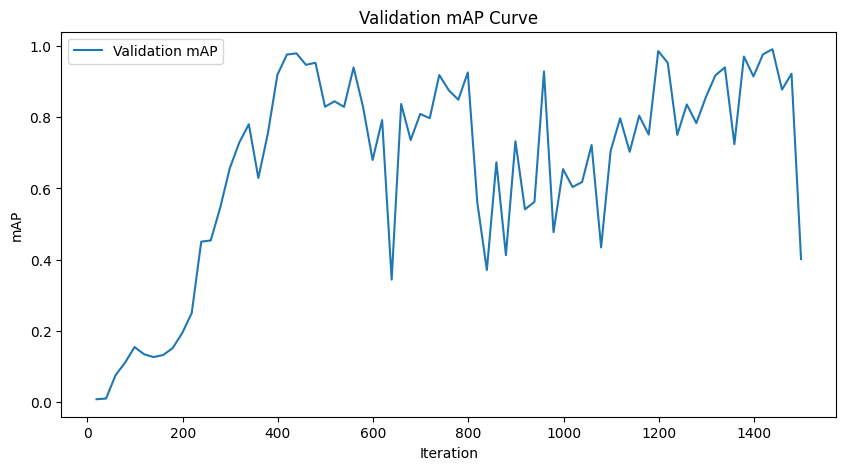

In [16]:
# 绘制MAP曲线
plt.figure(figsize=(10, 5))
plt.plot(iterations, map_values, label='Validation mAP')
plt.xlabel('Iteration')
plt.ylabel('mAP')
plt.title('Validation mAP Curve')
plt.legend()
plt.show()

In [ ]:
import torch
torch.save(trainer.model.state_dict(), path+"/model_weights.pth")

In [17]:
# 配置
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS =  path+"/model_weights.pth" # 加载权重
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75  # 可以调整阈值
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 20  # VOC 的类别数量

# 创建预测器
predictor = DefaultPredictor(cfg)

In [18]:
test_path  = '/mnt/d/复旦/研究生/研一下/神经网络与深度学习/Homework2/VOC2012test/VOCdevkit/VOC2012/JPEGImages'
image_paths = [test_path+"/2008_000370.jpg",test_path+"/2008_000671.jpg",test_path+"/2008_000954.jpg",test_path+"/2008_000951.jpg"]

In [19]:
for image_path in image_paths:
    # 读取图片
    image = cv2.imread(image_path)
    if image is None:
        continue
    
    # 进行预测
    outputs = predictor(image)

    # 可视化
    v = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # 显示图片
    cv2.imshow("Prediction", out.get_image()[:, :, ::-1])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [9]:
sample_path  = '/mnt/d/复旦/研究生/研一下/神经网络与深度学习/Homework2/VOC2012test/VOCdevkit/VOC2012/sample'
sample_image_paths = [sample_path+"/000001.jpg",sample_path+"/000002.jpg",sample_path+"/000003.jpg"]#

In [10]:
for image_path in sample_image_paths:
    # 读取图片
    image = cv2.imread(image_path)
    if image is None:
        continue
    
    # 进行预测
    outputs = predictor(image)

    # 可视化
    v = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # 显示图片
    cv2.imshow("Prediction", out.get_image()[:, :, ::-1])
    cv2.waitKey(0)
    cv2.destroyAllWindows()